## Project Description

The goal of this project is to build a **Convolutional Neural Network (CNN)** using **TensorFlow** to categorize chest X-ray images.

The dataset consists of two categories:  
- **Normal** (healthy patients)  
- **Pneumonia** (patients diagnosed with pneumonia)  

The data is organized into three subsets:  
- **Training set** – used to train the model  
- **Validation set** – used during training to tune hyperparameters and monitor performance  
- **Test set** – used after training to evaluate the final performance on unseen data  


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score, confusion_matrix
import os
import time
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# === DATASET ACCESS BLOCK: RUN THIS BLOCK TO DOWNLOAD DATASET ===
# Function to check if dataset is already extracted
def dataset_ready():
    return os.path.exists("chest_xray/train") and os.path.exists("chest_xray/test") and os.path.exists("chest_xray/val")

# Only download if not already present
if not dataset_ready():
    print("Accessing dataset from shared Google Drive (this may take a few minutes)...")

    start_time = time.time()

    # Install gdown for better Google Drive large file handling
    !pip install -q gdown

    # Download directly from your shared Google Drive link
    !gdown --id 1xTqvghtgVgLDrzEiS0ZNL6-Cx26jk91- -O chest_xray.zip

    print(f"Download completed in {(time.time() - start_time)/60:.1f} minutes. Extracting files...")

    # Extract the dataset
    !unzip -q chest_xray.zip

    # Remove macOS placeholder files if present
    !find chest_xray/__MACOSX -delete

    print(f"Setup completed in {(time.time() - start_time)/60:.1f} minutes total.")
else:
    print("Dataset already prepared!")

Accessing dataset from shared Google Drive (this may take a few minutes)...
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1xTqvghtgVgLDrzEiS0ZNL6-Cx26jk91-
From (redirected): https://drive.google.com/uc?id=1xTqvghtgVgLDrzEiS0ZNL6-Cx26jk91-&confirm=t&uuid=111eb60a-94cb-49a3-9613-b96674be293d
To: /content/chest_xray.zip
100% 1.24G/1.24G [00:24<00:00, 51.2MB/s]
Download completed in 0.6 minutes. Extracting files...
Setup completed in 0.8 minutes total.


## Loading Training and Test Datasets

In this step, we load the X-ray images from folders using `image_dataset_from_directory`.  
The function automatically recognizes the two classes (**normal** and **pneumonia**) from the subfolders and assigns labels (0 and 1).

- **Training dataset:** images are loaded and automatically divided into batches, ready for training the CNN model.  
  Since the **validation dataset (`val_ds`) contains only 16 images**, we will **not use it**. Instead, we will split the training dataset **80-20** to create a training and validation set.  

- **Test dataset:** images are loaded separately and will be used **only for final evaluation**.


In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_ds = image_dataset_from_directory(
    directory='chest_xray/train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='int'
)

test_ds = image_dataset_from_directory(
    directory='chest_xray/test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='int'
)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [ ]:
val_ds = image_dataset_from_directory(
    directory='chest_xray/val',
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

Found 16 files belonging to 2 classes.


## Visualizing Sample Images from the Training Dataset

In this step, we take a single batch from the training dataset and randomly select three images to visualize.
Each selected image is displayed with its corresponding label (normal or pneumonia).

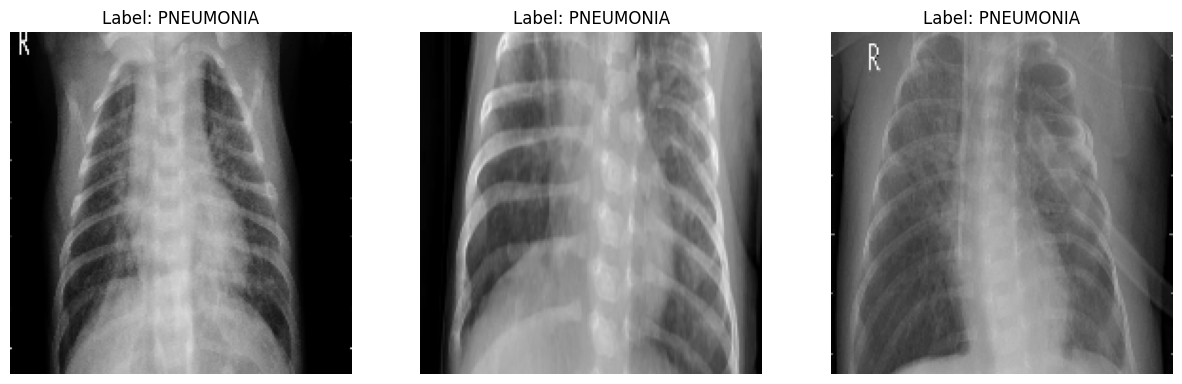

In [4]:
def display_random_samples(dataset, class_names, n):

  for images, labels in dataset.take(1):
    batch_size = images.shape[0]
    random_indexes = random.sample(range(batch_size), n)

    plt.figure(figsize=(15, 5))

    # enumerate nam daje: redni broj u petlji (i) i sâm indeks (idx).
    for i, idx in enumerate(random_indexes):
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[idx].numpy().astype("uint8"))
        plt.title(f"Label: {dataset.class_names[labels[idx]]}")
        plt.axis("off")

    plt.show()

class_names = train_ds.class_names
display_random_samples(train_ds, class_names, n=3)



In [ ]:
def class_distribution(dataset):
    count_0 = 0
    count_1 = 0

    for images_batch, labels in dataset:
        labels_np = labels.numpy()
        count_0 += np.sum(labels_np == 0)
        count_1 += np.sum(labels_np == 1)

    total = count_0 + count_1
    percent_0 = (count_0 / total) * 100
    percent_1 = (count_1 / total) * 100


    print(f"NORMAL: {count_0} ({percent_0:.2f}%)")
    print(f"PNEUMONIA: {count_1} ({percent_1:.2f}%)")


In [ ]:
print("Train set class distribution:")
class_distribution(train_ds)

print("\nTest set class distribution:")
class_distribution(test_ds)

Train set class distribution:
NORMAL: 1341 (25.71%)
PNEUMONIA: 3875 (74.29%)

Test set class distribution:
NORMAL: 234 (37.50%)
PNEUMONIA: 390 (62.50%)


## Preprocessing

Previously, we loaded `train_ds` and `test_ds` **only to inspect the dataset** and to display **sample images or class distribution**.

Now, we create the **actual data generators for training**, which include:

- **Augmentations** (rotation, flip, zoom, etc.)  
- **80-20 split** of the training set into **train and validation** subsets  
- **Normalization** of image pixel values  

In [ ]:
def preprocess_data(img_size, batch_size, train_dir='chest_xray/train', test_dir='chest_xray/test'):


    # Augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,         # horizontalno pomeranje
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,          # horizontalno okretanje
        fill_mode='nearest',           # punjenje novih piksela
        validation_split=0.2           # 80-20 split za train/validation
    )

    # Normalization for test
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Train
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',           # NORMAL0, PNEUMONIA 1
        subset='training',             # 80%
        shuffle=True
    )

    # Validation
    val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation',           # 20%
        shuffle=True
    )

    # Test
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    return train_generator, val_generator, test_generator


In [ ]:
train_gen, val_gen, test_gen = preprocess_data(img_size=(180, 180), batch_size=32)


Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Model Building Section



In [ ]:
from tensorflow.keras import layers, models

def create_model(input_shape):

    model = models.Sequential([
        layers.Input(shape=input_shape),


        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),


        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),


        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Flatten and Dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])


    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model




In [ ]:
model = create_model(input_shape=(180, 180, 3))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,023,361 (30.61 MB)

 Trainable params: 8,023,361 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.applications import MobileNetV2

def create_pretrained_model(input_shape):

    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,   # uklanja krajnji Dense sloj
        weights='imagenet'
    )
    base_model.trainable = False  # težine slojeva se ne menjaju tokom treninga

    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
pretrained_model = create_pretrained_model(input_shape=(180, 180, 3))
pretrained_model.summary()

/tmp/ipython-input-1804429228.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 6, 6, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Training and Evaluation Framework


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

def train_model(model, train_generator, val_generator, epochs=10):

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=callbacks
    )
    return history, model


In [ ]:

def evaluate_model(model, test_generator):

    # Evaluate loss and accuracy
    loss, acc = model.evaluate(test_generator)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {acc:.4f}\n")

    # --- Predict classes ---
    test_generator.reset()
    preds = model.predict(test_generator)
    preds_classes = (preds > 0.5).astype(int).flatten()
    true_classes = test_generator.classes

    # --- Confusion Matrix ---
    class_labels = ['NORMAL', 'PNEUMONIA']
    cm = confusion_matrix(true_classes, preds_classes)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # --- Classification report ---
    print("Classification Report:\n")
    print(classification_report(true_classes, preds_classes, target_names=class_labels))


In [ ]:
history, trained_model = train_model(model, train_gen, val_gen, epochs=10)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.7155 - loss: 0.6382

131/131 ━━━━━━━━━━━━━━━━━━━━ 91s 641ms/step - accuracy: 0.7159 - loss: 0.6370 - val_accuracy: 0.8591 - val_loss: 0.2883
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 79s 601ms/step - accuracy: 0.8555 - loss: 0.3235 - val_accuracy: 0.8715 - val_loss: 0.2964
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.8926 - loss: 0.2705

131/131 ━━━━━━━━━━━━━━━━━━━━ 78s 597ms/step - accuracy: 0.8926 - loss: 0.2704 - val_accuracy: 0.8715 - val_loss: 0.2659
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.8902 - loss: 0.2690

131/131 ━━━━━━━━━━━━━━━━━━━━ 79s 604ms/step - accuracy: 0.8902 - loss: 0.2689 - val_accuracy: 0.8917 - val_loss: 0.2415
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.9153 - loss: 0.2316

131/131 ━━━━━━━━━━━━━━━━━━━━ 78s 593ms/step - accuracy: 0.9153 - loss: 0.2316 - val_accuracy: 0.9252 - val_loss: 0.2004
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 78s 595ms/step - accuracy: 0.9200 - loss: 0.2055 - val_accuracy: 0.8965 - val_loss: 0.2380
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.9224 - loss: 0.2082

131/131 ━━━━━━━━━━━━━━━━━━━━ 78s 594ms/step - accuracy: 0.9224 - loss: 0.2082 - val_accuracy: 0.9156 - val_loss: 0.1979
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.9232 - loss: 0.2058

131/131 ━━━━━━━━━━━━━━━━━━━━ 78s 593ms/step - accuracy: 0.9232 - loss: 0.2058 - val_accuracy: 0.9195 - val_loss: 0.1978
Epoch 9/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.9336 - loss: 0.1764

131/131 ━━━━━━━━━━━━━━━━━━━━ 77s 588ms/step - accuracy: 0.9335 - loss: 0.1765 - val_accuracy: 0.9329 - val_loss: 0.1781
Epoch 10/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 80s 608ms/step - accuracy: 0.9266 - loss: 0.1919 - val_accuracy: 0.9252 - val_loss: 0.1879


In [ ]:
history_pretrained = pretrained_model.fit(train_gen, validation_data=val_gen, epochs=10)

/tmp/ipython-input-1804429228.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 122s 801ms/step - accuracy: 0.8331 - loss: 0.4133 - val_accuracy: 0.9338 - val_loss: 0.1546
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 78s 597ms/step - accuracy: 0.9296 - loss: 0.1701 - val_accuracy: 0.9406 - val_loss: 0.1448
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 79s 604ms/step - accuracy: 0.9314 - loss: 0.1627 - val_accuracy: 0.9415 - val_loss: 0.1357
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 78s 595ms/step - accuracy: 0.9438 - loss: 0.1413 - val_accuracy: 0.9501 - val_loss: 0.1283
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 79s 607ms/step - accuracy: 0.9478 - loss: 0.1374 - val_accuracy: 0.9492 - val_loss: 0.1399
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 77s 591ms/step - accuracy: 0.9457 - loss: 0.1313 - val_accuracy: 0.9530 - val_loss: 0.1226
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 78s 599ms/step - accuracy: 0.9475 - loss: 0.1341 - val_accuracy: 0.9329 - val_loss: 0.1851
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 79s 601ms/step - accuracy: 0.9431 - loss: 

## Visualization Utilities


In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):

    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


=== Evaluacija za CNN model from scratch ===


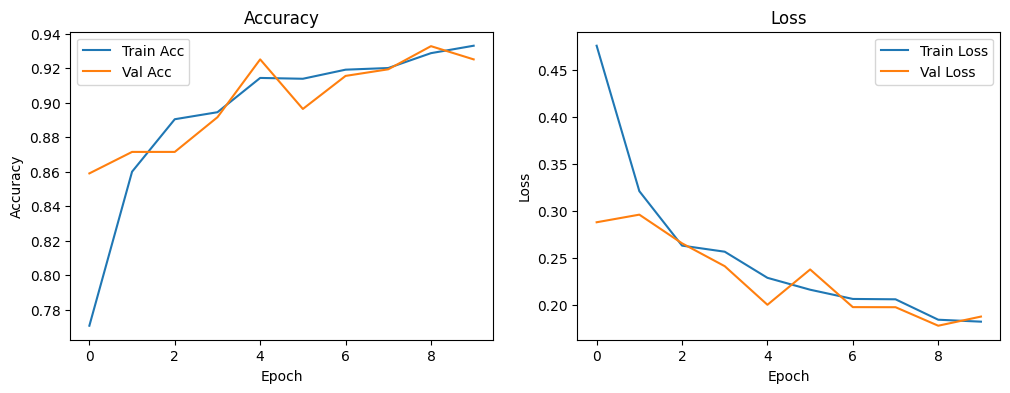

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.7593 - loss: 0.5921
Test Loss: 0.3661
Test Accuracy: 0.8542

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step


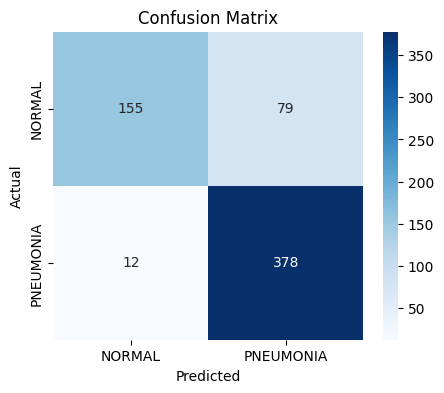

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.93      0.66      0.77       234
   PNEUMONIA       0.83      0.97      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.82      0.83       624
weighted avg       0.87      0.85      0.85       624



In [ ]:
print("Evaluacija za CNN model")

plot_training_history(history)
evaluate_model(trained_model, test_gen)

=== Evaluacija za pretrained model (MobileNetV2) ===


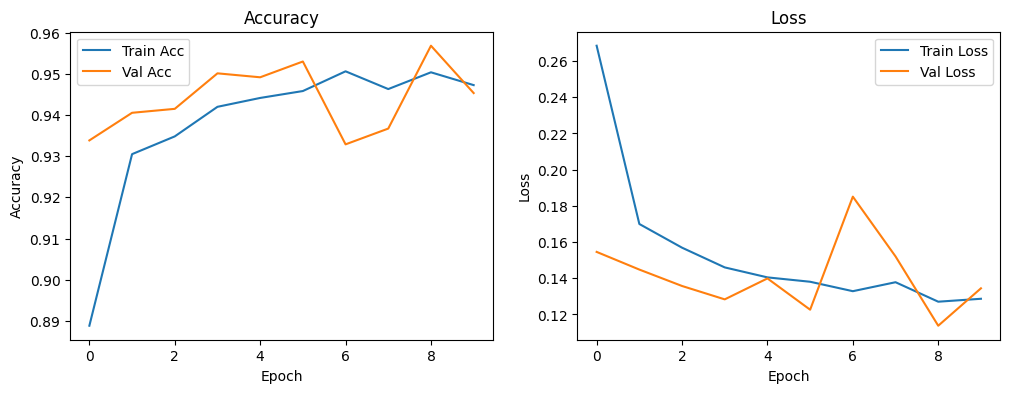

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 343ms/step - accuracy: 0.8912 - loss: 0.2664
Test Loss: 0.2138
Test Accuracy: 0.9135

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step


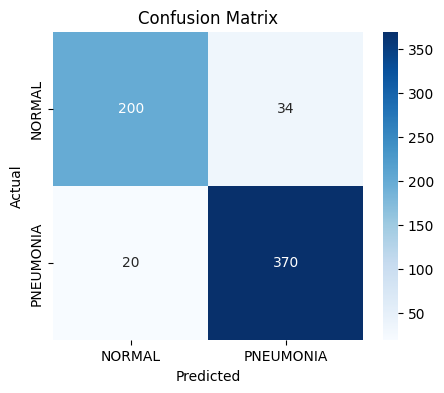

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.91      0.85      0.88       234
   PNEUMONIA       0.92      0.95      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.90      0.91       624
weighted avg       0.91      0.91      0.91       624



In [ ]:
print("Evaluacija za pretrained model (MobileNetV2)")

plot_training_history(history_pretrained)
evaluate_model(pretrained_model, test_gen)